In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import scipy
from matplotlib.gridspec import GridSpec
from __future__ import print_function
from mailmerge import MailMerge
import shutil
import openpyxl
from scipy.optimize import curve_fit
from time import gmtime, strftime
from ipywidgets import FloatProgress
from ipywidgets import IntProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-06 07:45:33


In [2]:
# Defining Parameteres
print(strftime("%Y-%m-%d %H:%M:%S"))
Years = range(2012,2017)
MaxOpenProcesses = 15
Project_DIR  = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO00_OtherStates\NewMexico\3_WorkData\7_NetworkScreening'
ReceivedDir  = Project_DIR + '\\2.Received_Data'
Project_GDB  = Project_DIR + '\\5.NM_NS_GDB.gdb'
PythonDir   = Project_DIR + '\\6.Python_Notebook'

Src_Loc  = ReceivedDir + '\\crash_asof_11jun2018.csv'
Src_Unit = ReceivedDir + '\\vehicle_asof_11jun2018.csv'
Src_Occ  = ReceivedDir + '\\occupant_asof_11jun2018.csv'

Src_Ped_Loc  = ReceivedDir + '\\Ped_2017_KAB\\crashkabped.csv'
Src_Ped_Unit = ReceivedDir + '\\Ped_2017_KAB\\vehiclekabped.csv'
Src_Ped_Occ  = ReceivedDir + '\\Ped_2017_KAB\\occkabped.csv'

HPMS105 = {year:ReceivedDir + '\\v105\\jg_request.gdb\\HPMS{}Data'.format(year) for year in Years}
HPMS10  = {year:ReceivedDir + '\\v10\\jg_request.gdb\\HPMS{}Data'.format(year) for year in Years}

FOU_2017_105 = ReceivedDir + '\\v105\\jg_request.gdb\\HPMS2017Ownership_Urban_FuncSys'
FOU_2017_10  = ReceivedDir + '\\v10\\jg_request.gdb\\HPMS2017Ownership_Urban_FuncSys'

FHWA_HPMS     = {year:ReceivedDir + '\\FHWA_HPMS\\newmexico{}\\NewMexico{}.shp'.format(year,year) for year in Years}
MS2_HPMS_2017 = {year:ReceivedDir + '\\NM_HPMS_N2017_A{}.csv'.format(year) for year in Years}

Routes  = {year:Project_GDB + '\\Routes_{}'.format(year) for year in Years}
AttTabs = {year:Project_GDB + '\\SegAtt_{}'.format(year) for year in Years}
Segs    = {year:Project_GDB + '\\Seg_{}'.format(year) for year in Years}
CrashData = {year:Project_GDB + '\\Crash_{}'.format(year) for year in range(2012,2018)}

UTM13N   = arcpy.SpatialReference(26913)
NAD83_NM = arcpy.SpatialReference(6529)

RouteID = "ROUTE_ID"
BEG_STA = 'BEG_POINT'
END_STA = 'END_POINT'
Fields = ['F_SYSTEM','THROUGH_LANES','FACILITY_TYPE','AADT','MEDIAN_TYPE','SPEED_LIMIT','LANE_WIDTH']

2018-11-06 07:45:33


In [3]:
hsmpy3.nm.CON_CalculatePSIValues(Project_DIR,HSMPY_PATH,
    Segs,
    CrashData,
    Project_DIR + '\\6.Python_Notebook\\Seg_SPFs.csv',
    Project_DIR + '\\8.Deliverable\\TopSegments_PSI2.csv',
    Project_DIR +'\\8.Deliverable\\CompiledData.gdb'
)

Highest risk—5 percent of highway system length, shown in black.
• Medium-high risk—10 percent of highway system length, shown in red.
• Medium risk—20 percent of highway system length, shown in yellow.
• Medium-low risk—25 percent of highway system length, shown in light green.
• Lowest risk—40 percent of highway system length, shown in dark green.

In [5]:
# Read Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Crash_DF = pd.concat([hsmpy3.common.FCtoDF(CrashData[year],readGeometry=True) for year in range(2012,2018)])
Crash_DF['Year'] = [d.year for d in Crash_DF.Date]
Crash_DF['PedCrashCount'] = [{True:1,False:0}[sum([k,a,b])>0] for k,a,b in zip(Crash_DF.PedK,Crash_DF.PedA,Crash_DF.PedB)]
Crash_DF['Count'] = 1
Crash_DF['KAB'] = Crash_DF.Killed + Crash_DF.ClassA + Crash_DF.ClassB
Crash_DF.index = ['{}_{}'.format(y,u) for u,y in zip(Crash_DF.UCRnum,Crash_DF.Year)]
Crash_DF.index.name = 'CID'
Crash_DF = Crash_DF.drop('CID',axis=1)
display(pd.DataFrame(Crash_DF.groupby(['Year'])['Count','Killed','ClassA','ClassB','PedCrashCount','PedK','PedA','PedB'].aggregate(np.sum)))
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-10-29 12:26:52


Count  Killed  ClassA  ClassB  PedCrashCount  PedK  PedA  PedB
Year                                                                
2012   4143     362    1592    3456            242    61    58   129
2013   4069     311    1290    3534            281    53    95   141
2014   4398     384    1241    3840            350    74    94   189
2015   4903     298    1325    4511            378    55   126   211
2016   5048     405    1153    4750            353    77    84   204
2017    342      74      83     197            342    74    82   191

2018-10-29 12:28:25


In [ ]:
RDF = hsmpy3.common.FCtoDF(Routes[2016])
RDF.index = RDF.ROUTE_ID
RDF = RDF.drop(['Shape_Length','partCount'],axis=1)
RDF.shape

In [66]:
Segs_DF = hsmpy3.common.FCtoDF(Segs[2016])
Segs_DF = Segs_DF.loc[[s.split('-')[2]=='P' for s in Segs_DF.ROUTE_ID]]

In [264]:
Segs_DF15 = hsmpy3.common.FCtoDF(Segs[2015])
Segs_DF15 = Segs_DF15.loc[[s.split('-')[2]=='P' for s in Segs_DF15.ROUTE_ID]]
Segs_DF14 = hsmpy3.common.FCtoDF(Segs[2014])
Segs_DF14 = Segs_DF14.loc[[s.split('-')[2]=='P' for s in Segs_DF14.ROUTE_ID]]
Segs_DF13 = hsmpy3.common.FCtoDF(Segs[2013])
Segs_DF13 = Segs_DF13.loc[[s.split('-')[2]=='P' for s in Segs_DF13.ROUTE_ID]]
Segs_DF12 = hsmpy3.common.FCtoDF(Segs[2012])
Segs_DF12 = Segs_DF12.loc[[s.split('-')[2]=='P' for s in Segs_DF12.ROUTE_ID]]

In [93]:
SPF = pd.read_csv('Seg_SPFs.csv',index_col=0)
SPF.index = SPF.Type
SPF


Type  Intercept      AADT  Dispersion
Type                                      
R2U   R2U  -6.840424  0.574385    0.725390
R4D   R4D  -7.064281  0.649505    0.858935
R4U   R4U  -7.612892  0.684523    0.787486
U2U   U2U  -6.478442  0.422186    0.939196
U4U   U4U  -7.558023  0.657491    1.546703
U4D   U4D  -9.348186  0.837544    0.582183
U6U   U6U  -6.571942  0.553122    0.817989

In [4]:
Loc_DF = pd.read_csv(Src_Loc,low_memory=False)
Loc_DF.index = ['{}_{}'.format(y,u) for y,u in zip(Loc_DF.year,Loc_DF.UCRnumber)]
Veh_DF = pd.read_csv(Src_Unit,low_memory=False)
Veh_DF.index = ['{}_{}'.format(y,u) for y,u in zip(Veh_DF.year,Veh_DF.UCRnumber)]
Occ_DF = pd.read_csv(Src_Occ,low_memory=False)
Occ_DF.index = ['{}_{}'.format(y,u) for y,u in zip(Occ_DF.year,Occ_DF.UCRnumber)]
#Trk_idx = Loc_DF[Loc_DF.TRKinv==1].index

In [7]:
l = list(Loc_DF);l.sort();print(l)
l = list(Veh_DF);l.sort();print(l)
l = list(Occ_DF);l.sort();print(l)

['Agency', 'Alcinv', 'Analysis', 'Astreet', 'Bstreet', 'CADNumber', 'CaseNumber', 'City', 'Class', 'ClassA', 'ClassB', 'ClassC', 'County', 'CrashDate', 'CrashDirection', 'CrashOccurrence', 'Day', 'DirectionFromLandmark', 'Druginv', 'Fatal_Injury', 'FormID', 'GIS_LAT', 'GIS_LONG', 'GIS_MAINTDIST', 'GIS_Milepost', 'GIS_NATAMER_USCENSUS', 'GIS_Route', 'GIS_SPDIST', 'GIS_TRANSDIST', 'GIS_UTMX', 'GIS_UTMY', 'HZinv', 'HitRun', 'Hour', 'Injured', 'Killed', 'Landmark', 'Light', 'MCinv', 'MaxDam', 'Measurement', 'MeasurementUnit', 'MilitaryTime', 'Month', 'MotorVeh', 'Motorists', 'NMDOTNumber', 'NonLocal', 'NonMotorists', 'NumberofDrawings', 'PECinv', 'PEDinv', 'PropertyDamage', 'ReportDate', 'RoadCharacter', 'RoadGrade', 'SHDTPROP', 'Severity', 'StampDate', 'StationReport', 'SysScanDate', 'System', 'TRKinv', 'TimeArrived', 'TimeNotified', 'TopCFacc', 'Total', 'TraCS', 'TribalJurisdiction', 'UCRnumber', 'Unhurt', 'UrbnRurl', 'Weather', 'WitnessPresent', 'dateAddedDB', 'nVeh', 'pDesc', 'pState',

In [8]:
idx_C = set(list(Loc_DF.index))
idx_V = set(list(Veh_DF.index))
idx_O = set(list(Occ_DF.index))

In [8]:
Veh_DF.TrafficControlDevice.value_counts().sort_index()

1      2065
2      2887
3      9748
4       159
5        40
6       275
7       138
9     20137
10     3697
98       68
99     1799
Name: TrafficControlDevice, dtype: int64

In [378]:
print(strftime("%Y-%m-%d %H:%M:%S"))
PSI_DF = pd.DataFrame()
Prg = IntProgress(value=0,min=0,max=Segs_DF.shape[0],step=1)
display(Prg)
for i,r in Segs_DF.iterrows():
    rid = r.ROUTE_ID
    bmp = r.BEG_POINT
    emp = r.END_POINT
    df = Crash_DF[(Crash_DF.RID_P==rid) & (Crash_DF.MP_P>=bmp) & (Crash_DF.MP_P<=emp)]
    CL_R = list(df[df.PedCrashCount==1]['MP_P'])
    CL_R.sort()
    if len(CL_R)==0:
        Prg.value+=1
        continue
    if r.URBAN_CODE in [0,99999]:
        SW = 1
        Inc = 0.2
    else:
        SW = 0.25
        Inc = .05
    df2 = SlidingWindow(bmp,emp,CL_R,SW,Inc)
    df3 = DissolveDF(df2)
    df3['RID'] = rid
    df3['FType'] = r.FType
    df3['AADT'] = r.AADT
    df3['F_SYSTEM'] = r.F_SYSTEM
    df3['FACILITY_TYPE'] = r.FACILITY_TYPE
    df3['OWNERSHIP'] = r.OWNERSHIP
    df3['URBAN_CODE'] = r.URBAN_CODE
    df3['THROUGH_LANES'] = r.THROUGH_LANES
    df3['MEDIAN_TYPE'] = r.MEDIAN_TYPE
    df3['SPEED_LIMIT'] = r.SPEED_LIMIT
    
    df3['Length'] = df3.EMP-df3.BMP
    #if r.FType in SPF.index and r.AADT>0:
    #    df3['a'] = SPF.loc[r.FType,'Intercept']
    #    df3['b'] = SPF.loc[r.FType,'AADT']
    #    df3['k'] = SPF.loc[r.FType,'Dispersion']
    #    df3['k_l'] = df3['k']/SW
    #    df3['pred16'] = [math.exp(a)*aadt**b*SW for a,b,aadt in zip(df3.a,df3.b,df3.AADT)]
    #    df3['pred15'] = [GetPred(Segs_DF15,rid,bmp1,emp1,a,b,SW) for a,b,bmp1,emp1 in zip(df3.a,df3.b,df3.BMP,df3.EMP)]
    #    df3['pred14'] = [GetPred(Segs_DF14,rid,bmp1,emp1,a,b,SW) for a,b,bmp1,emp1 in zip(df3.a,df3.b,df3.BMP,df3.EMP)]
    #    df3['pred13'] = [GetPred(Segs_DF13,rid,bmp1,emp1,a,b,SW) for a,b,bmp1,emp1 in zip(df3.a,df3.b,df3.BMP,df3.EMP)]
    #    df3['pred12'] = [GetPred(Segs_DF12,rid,bmp1,emp1,a,b,SW) for a,b,bmp1,emp1 in zip(df3.a,df3.b,df3.BMP,df3.EMP)]
    #    df3['pred'] = [GetPred_Sum(p12,p13,p14,p15,p16) for p12,p13,p14,p15,p16 in zip(df3.pred16,df3.pred15,df3.pred14,df3.pred13,df3.pred12)]
    #    df3['w'] = [1.0/(1.0+k*p) for k,p in zip(df3.k,df3.pred)]
    #    df3['exp'] = [p*w+(1-w)*o for p,w,o in zip(df3.pred,df3.w,df3.CrashFreq)]
    #    df3['psi'] = df3.exp - df3.pred
    PSI_DF = pd.concat([PSI_DF,df3])
    Prg.value+=1
#PSI_DF.columns = ['BMP', 'EMP', 'CrashFreq', 'RID', 'FType', 'AADT', 'Length', 'SPF_A', 'SPF_B', 'SPF_k', 'Seg_k', 'SPF_Pred', 'EB_w', 'EB_Exp', 'PSI']
#PSI_DF = PSI_DF[['RID','BMP', 'EMP','Length','FType', 'AADT', 'CrashFreq',     'SPF_A', 'SPF_B', 'SPF_k', 'Seg_k', 'EB_w', 'SPF_Pred', 'EB_Exp', 'PSI']]
#PSI_DF = PSI_DF.sort_values(['RID','BMP'])
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-05 10:36:30


IntProgress(value=0, max=224236)

2018-11-05 11:15:12


In [358]:
PSI_DF['CF_Pred'] = [GetPred_Sum(p12,p13,p14,p15,p16) for p12,p13,p14,p15,p16 in zip(PSI_DF.CF_Pred_2012,PSI_DF.CF_Pred_2013,PSI_DF.CF_Pred_2014,PSI_DF.CF_Pred_2015,PSI_DF.CF_Pred_2016)]
PSI_DF['EB_w'] = [1.0/(1.0+k*p) for k,p in zip(PSI_DF.Seg_k,PSI_DF.CF_Pred)]
PSI_DF['CF_Exp'] = [p*w+(1-w)*o for p,w,o in zip(PSI_DF.CF_Pred,PSI_DF.EB_w,PSI_DF.CF_Obs)]
PSI_DF['PSI'] = PSI_DF.CF_Exp - PSI_DF.CF_Pred

In [380]:
#PSI_DF[['RID', 'BMP','EMP', 'Length','FType','AADT', 'CrashFreq',  'a', 'b', 'exp', 'k', 'k_l', 'pred', 'psi', 'w']]
PSI_DF.rename(columns={'a':'SPF_a','b':'SPF_b','exp':'CF_Exp','pred':'CF_Pred','psi':'PSI','w':'EB_w','k':'SPF_k','k_l':'Seg_k',
                      'CrashFreq':'CF_Obs','AADT':'AADT_2016','pred12':'CF_Pred_2012','pred13':'CF_Pred_2013','pred14':'CF_Pred_2014',
                      'pred15':'CF_Pred_2015','pred16':'CF_Pred_2016'},inplace=True)
PSI_DF = PSI_DF[['RID', 'BMP','EMP', 'Length','FType','AADT_2016',
        'F_SYSTEM','FACILITY_TYPE','OWNERSHIP','URBAN_CODE','THROUGH_LANES','MEDIAN_TYPE','SPEED_LIMIT',
        'CF_Obs']]

In [372]:
#PSI_DF[['RID', 'BMP','EMP', 'Length','FType','AADT', 'CrashFreq',  'a', 'b', 'exp', 'k', 'k_l', 'pred', 'psi', 'w']]
PSI_DF.rename(columns={'a':'SPF_a','b':'SPF_b','exp':'CF_Exp','pred':'CF_Pred','psi':'PSI','w':'EB_w','k':'SPF_k','k_l':'Seg_k',
                      'CrashFreq':'CF_Obs','AADT':'AADT_2016','pred12':'CF_Pred_2012','pred13':'CF_Pred_2013','pred14':'CF_Pred_2014',
                      'pred15':'CF_Pred_2015','pred16':'CF_Pred_2016'},inplace=True)
PSI_DF = PSI_DF[['RID', 'BMP','EMP', 'Length','FType','AADT_2016',
        'F_SYSTEM','FACILITY_TYPE','OWNERSHIP','URBAN_CODE','THROUGH_LANES','MEDIAN_TYPE','SPEED_LIMIT',
        'CF_Obs','CF_Pred','CF_Exp','PSI','CF_Pred_2012','CF_Pred_2013','CF_Pred_2014','CF_Pred_2015','CF_Pred_2016', 
        'SPF_a', 'SPF_b', 'SPF_k', 'Seg_k', 'EB_w']]

KeyError: "['CF_Pred' 'CF_Exp' 'PSI' 'CF_Pred_2012' 'CF_Pred_2013' 'CF_Pred_2014'\n 'CF_Pred_2015' 'CF_Pred_2016' 'SPF_a' 'SPF_b' 'SPF_k' 'Seg_k' 'EB_w'] not in index"

In [363]:
def GetPred_Sum(p12,p13,p14,p15,p16):
    df = pd.DataFrame(columns=['Pred'],index=range(2012,2017))
    df.loc[2012,'Pred'] = p12
    df.loc[2013,'Pred'] = p13    
    df.loc[2014,'Pred'] = p14    
    df.loc[2015,'Pred'] = p15    
    df.loc[2016,'Pred'] = p16
    df = df[df.Pred>0]
    if df.shape[0]>0:
        return(5*df.Pred.mean())
    else:
        return(0)
GetPred_Sum(0,1,0,0,0)

5.0

In [361]:
def GetPred(Seg_DF,rid,bmp,emp,a,b,SW):
    df = Seg_DF[Seg_DF.ROUTE_ID==rid][['ROUTE_ID','BEG_POINT','END_POINT','AADT']]
    #display(df)
    df = df.sort_values('BEG_POINT')
    df = df[(df.BEG_POINT>=bmp) | ((df.BEG_POINT<bmp) & (df.END_POINT>bmp))]
    df = df[(df.END_POINT<=emp) | ((df.BEG_POINT<emp) & (df.END_POINT>emp))]
    df.set_value(list(df.index)[0],'BEG_POINT',bmp)
    df.set_value(list(df.index)[-1],'END_POINT',emp)
    df['Length'] = df.END_POINT - df.BEG_POINT
    df['a'] = a
    df['b'] = b
    df['pred'] = [math.exp(a)*aadt**b*leng for a,b,aadt,leng in zip(df.a,df.b,df.AADT,df.Length)]
    #df['pred'] = df['pred']/df['Length']*SW
    #display(df)
    o = df.pred.sum()/df.Length.sum()*SW
    return(o)
GetPred(Segs_DF15,'US-84-P',91,92,-7,0.6,1)

0.079884931947675278

In [ ]:
Int_DF = hsmpy3.common.FCtoDF(Project_GDB+'\\Int_2016',readGeometry=True)
Int_DF.index = Int_DF.Int_ID
Int_DF['X'] = [s.firstPoint.X for s in Int_DF.Shape]
Int_DF['Y'] = [s.firstPoint.Y for s in Int_DF.Shape]
df = pd.DataFrame(Crash_DF[Crash_DF.Int_ID>0].groupby('Int_ID')['KAB'].aggregate([np.size,sum]))
Int_DF['CF_Obs'] = df.loc[Int_DF.index,'size']
Int_DF.CF_Obs = Int_DF.CF_Obs.fillna(0)
Int_DF[Int_DF.CF_Obs>0].to_excel('Int_CF.xlsx')

In [412]:
print(strftime("%Y-%m-%d %H:%M:%S"))
GDB = Project_DIR +'\\8.Deliverable\\CompiledData.gdb'
TopSeg_PSI_Table = hsmpy3.common.CreateOutPath(MainFile=GDB+'\\TopSeg_PSI',Extension='',appendix='table')
arcpy.management.CopyRows(
    in_rows=Project_DIR + '\\8.Deliverable\\TopSegments_PSI.xlsx\\Sheet1$',
    out_table=TopSeg_PSI_Table
)
TopSeg_PSI_Layer = hsmpy3.common.CreateOutLayer('TopSeg_PSI_Layer')
arcpy.lr.MakeRouteEventLayer(
    in_routes = GDB+'\\Routes_2016', 
    route_id_field = 'ROUTE_ID', 
    in_table = TopSeg_PSI_Table, 
    in_event_properties = 'RID Line BMP EMP', 
    out_layer = TopSeg_PSI_Layer
)
TopSeg_PSI_FC = hsmpy3.common.CreateOutPath(MainFile=GDB+'\\TopSeg',Extension='',appendix='PSI')
arcpy.management.CopyFeatures(
    in_features=TopSeg_PSI_Layer,
    out_feature_class=TopSeg_PSI_FC
)
arcpy.management.Delete(TopSeg_PSI_Layer)
arcpy.management.Delete(TopSeg_PSI_Table)
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-11-05 13:26:20


<Result 'true'>

In [415]:
arcpy.GetCount_management(TopSeg_PSI_FC)[0]

'2991'

In [396]:
Int_DF[Int_DF.CF_Obs>0].to_excel('Int_CF.xlsx')

In [376]:
PSI_DF[(PSI_DF.CF_Obs>0)].to_excel('Corridors_CF.xlsx')

In [382]:
PSI_DF[(PSI_DF.CF_Obs>0)].to_excel('Segments_PedCrashes_CF.xlsx')

In [202]:
PSI_DF.columns = ['EMP','AADT', 'BMP', 'RID','FType','Length', 'CrashFreq', 'SPF_A', 'SPF_B', 'EB_Exp', 'SPF_k', 'SPF_Pred', 'Seg_k', 'PSI', 'EB_w']
df = PSI_DF[['RID','BMP','EMP','Length','FType','AADT','CrashFreq','SPF_A', 'SPF_B', 'SPF_k', 'Seg_k', 'SPF_Pred', 'EB_w', 'EB_Exp', 'PSI']]
df = df.sort_values(['RID','BMP'])
df.to_csv('PSI3.csv')

In [221]:
def DissolveDF(df):
    df1 = pd.DataFrame(columns=['BMP','EMP','CrashFreq'])
    j = 0
    for i,r in df.iterrows():
        if i==0:
            j += 1
            df1.loc[j] = [r.BMP,r.EMP,r.CrashFreq]
        else:
            if r.CrashFreq>df1.loc[j,'CrashFreq']:
                if r.BMP < df1.loc[j,'BMP']:
                    df1.loc[j] = [df1.loc[j-1,'EMP'],r.EMP,r.CrashFreq]
                else:
                    df1.loc[j,'EMP'] = r.BMP
                    j += 1
                    df1.loc[j] = [r.BMP,r.EMP,r.CrashFreq]
            if r.CrashFreq<df1.loc[j,'CrashFreq']:
               j += 1
               df1.loc[j] = [df1.loc[j-1,'EMP'],r.EMP,r.CrashFreq]
            if r.CrashFreq==df1.loc[j,'CrashFreq']:
                df1.loc[j,'EMP'] = r.EMP
    if df1.EMP.max()<df.EMP.max():
        df1.loc[j,'EMP'] = df.EMP.max()
    return(df1)

In [156]:
def PlotSWRes(df,CL):
    plt.figure(figsize=(10,6))
    plt.gca().set_xlim([min(df.BMP),max(df.EMP)])
    plt.gca().set_ylim([min(df.CrashFreq)-1,max(df.CrashFreq)+1])
    plt.axhline(y=0, color='r', linestyle='-',label = 'Route (Linear Referencing)')
    plt.plot(CL,[0 for i in CL],'o',color = 'red',label='Crash Mileposts')
    plt.plot(df.Cen,df.CrashFreq,'-|',color='green',label = 'Sliding Window Residuals')
    Flag = False
    for i,r in df.iterrows():
        if r.Chosen:
            if not Flag:
                plt.plot([r.BMP,r.EMP],[r.CrashFreq,r.CrashFreq],'-|',color='b',label='High Windows')
                Flag = True
            else:
                plt.plot([r.BMP,r.EMP],[r.CrashFreq,r.CrashFreq],'-|',color='b')
            plt.plot([r.BMP,r.EMP],[0,0],'-|',color='b')
            plt.text((r.BMP+r.EMP)/2.0, -0.2, r.CrashFreq, fontsize=12,color='b')
    plt.grid()
    plt.xlabel('Milepost')
    plt.ylabel('Excess Expected Average Crash Frequency with EB Adjustment')
    plt.legend(loc='upper right')
    #L=plt.legend()
    #L.get_texts()[0].set_text('make it short')
    plt.savefig('slidingwindow.png',transparent=True)
    plt.show()
def SlidingWindow(BMP,EMP,CL,Len,Inc):
    n = 0
    if EMP-BMP>Len:
        n = int(float(EMP-BMP-Len)/Inc)
    BMPList = [BMP + i*Inc for i in range(0,n+1)]
    df = pd.DataFrame(columns = ['BMP','EMP','CrashFreq'])
    for i,bmp in enumerate(BMPList):
        if bmp+Len <= EMP:
            cl = [c for c in CL if c>=bmp and c<bmp+Len]
            df.loc[i] = [bmp,bmp+Len,len(cl)]
        else:
            cl = [c for c in CL if c>=bmp and c<=EMP]
            df.loc[i] = [bmp,EMP,len(cl)]
    Max_EMP = df.EMP.max()
    if Max_EMP<EMP:
        cl = [c for c in CL if c>=EMP-Len and c<=EMP]
        df.loc[i+1] = [EMP-Len,EMP,len(cl)]
        
    #ccdf = FindSegs(df,CL)
    #chosen = []
    #for i,r in df.iterrows():
    #    flag = False
    #    for j,k in ccdf.iterrows():
    #        if k.BMP==r.BMP and k.EMP==r.EMP:
    #            flag = True
    #            break
    #    chosen.append(flag)
    #df['Chosen'] = chosen
    return(df)
def ConvertIDtoFreq(s):
    if s == '':
        return 0
    else:
        return len(s.split(';'))
def FindSegs(df,CL):
    def OverlapControl(Seg,SegList):
        for seg in SegList:
            if (Seg[0]>= seg[0] and Seg[0]<= seg[1]) or (Seg[1]>= seg[0] and Seg[1]<= seg[1]):
                return False
        return True
    vcdf = pd.DataFrame(df.CrashFreq.value_counts()).sort_index(ascending=False)
    cidf = pd.DataFrame(df.CrashIDs.value_counts()).sort_index()
    cidf['CrashFreq'] = [ConvertIDtoFreq(s) for s in cidf.index]
    cidf['ID'] = cidf.index
    cidf=cidf.sort_values(by=['CrashFreq','CrashIDs'],ascending=False)
    bmp = []
    emp = []
    for i,r in cidf.iterrows():
        sdf = df[df.CrashIDs == r.name].copy()
        cl = [CL[int(j)] for j in r.name.split(';') if r.name!='']
        diff = []
        for j,k in sdf.iterrows():
            b = 0;e = 0
            if len(cl)>0:
                b = min(cl)-k.BMP 
                e = k.EMP-max(cl)
            diff.append(abs(b-e))
        sdf['Diff'] = diff
        sdf = sdf.sort_values('Diff')
        bmp.append(sdf.iloc[0]['BMP'])
        emp.append(sdf.iloc[0]['EMP'])
        #display(sdf)
        #print(cl)
    cidf['BMP'] = bmp
    cidf['EMP'] = emp
    chosenSegs = []
    res = []
    for i,r in cidf.iterrows():
        flag = OverlapControl([r.BMP,r.EMP],chosenSegs)
        if flag:
            chosenSegs.append([r.BMP,r.EMP])
        res.append(flag)
    cidf['Chosen'] = res
    ccdf = cidf[cidf.Chosen == True].copy()
    return(ccdf)
        

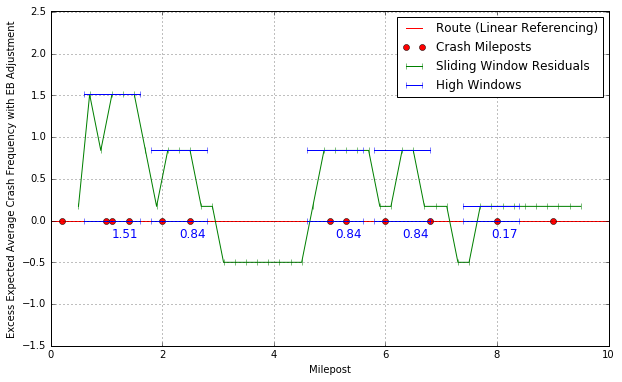

BMP  Cen  EMP  CrashFreq CrashIDs Chosen  Expected  Predicted
3   0.6  1.1  1.6       1.51    1;2;3   True      2.01        0.5
9   1.8  2.3  2.8       0.84      4;5   True      1.34        0.5
23  4.6  5.1  5.6       0.84      6;7   True      1.34        0.5
29  5.8  6.3  6.8       0.84      8;9   True      1.34        0.5
37  7.4  7.9  8.4       0.17       10   True      0.67        0.5

In [28]:
CL = [0.2,1,1.1,1.4,2,2.5,5,5.3,6,6.8,8,9]
df = SlidingWindow(BMP=0,EMP=10,CL = CL,Len=1,Inc=0.2)
df['Expected'] = df['CrashFreq'] * 0.67
df['Predicted'] = 0.5
df['CrashFreq'] = df['Expected'] - df['Predicted']
PlotSWRes(df,CL)
#df.to_html("deleteme.html")
#url = "http://localhost:8888/tree/Downloads/NM/deleteme.html"
#webbrowser.open(url,new=2)
display(df[df.Chosen])